### Nested Clustered Optimization

Nested Clustered Optimization은 wrapper라고 알려진 알고리즘의 종류에 속한다. 어떤 효율적 경계의 구성 원소가 계산되는지 여부나 어떤 제약 조건들이 부과되는지 여부에 대래서 무관하다. NCO는 마코위츠의 저주가 기존의 평균-분산 배분 방법에 미치는 영향을 해결하기 위한 전략을 제공한다.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings

warnings.filterwarnings('ignore')

TICKERS = pd.read_excel('S&P500_ticker_list.xlsx')['Symbol'].tolist()
START_DATE = '2010-01-01'
END_DATE = pd.to_datetime('today')

data = yf.download(
    TICKERS,
    start = START_DATE,
    end = END_DATE,
    progress = True
)['Close']

[*********************100%%**********************]  503 of 503 completed


In [3]:
data = data.resample('W').last().dropna(axis = 1)
ret = data.pct_change().dropna()

#### 상관 군집화

NCO알고리즘의 첫 번째 단계는 상관 행렬을 군집화하는 것이다. 이 작업에는 최적의 군집 수를 찾는 작업이 포함된다. 한가지 가능성은 ONC알고리즘을 적용하는 것이지만, NCO는 군집 수를 결정하는 데 사용되는 어떤 알고리즘이 사용되는가에 대해서 무관하다. $\frac{T}{N}$이 상대적으로 낮은 큰 행렬의 경우 Dimension Reduction에서 설명한 방법에 따라 군집화 전에 상관 행렬의 잡음을 제거하는 것이 바람직하다. 아래의 코드는 이 절차를 구현한다. 

In [9]:
from FinancialMachineLearning.utils.stats import *
from FinancialMachineLearning.machine_learning.clustering import *

nBlocks, bSize, bCorr, q  = 3, 2, .5, 10
cov0 = ret.cov()

In [12]:
corr0 = covariance_to_correlation(cov0)
eVal0, eVec0 = getPCA(corr0)
eMax0, var0 = find_max_eval(np.diag(eVal0), q, bWidth = 0.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)
corr1 = denoise_target_shrinkage(eVal0, eVec0, nFacts0)  # denoising by constant residual eigenvalue method
cov1 = correlation_to_covariance(corr1, np.diag(cov0) ** .5)

In [15]:
cov1 = pd.DataFrame(cov1, index = cov0.index, columns = cov0.columns)

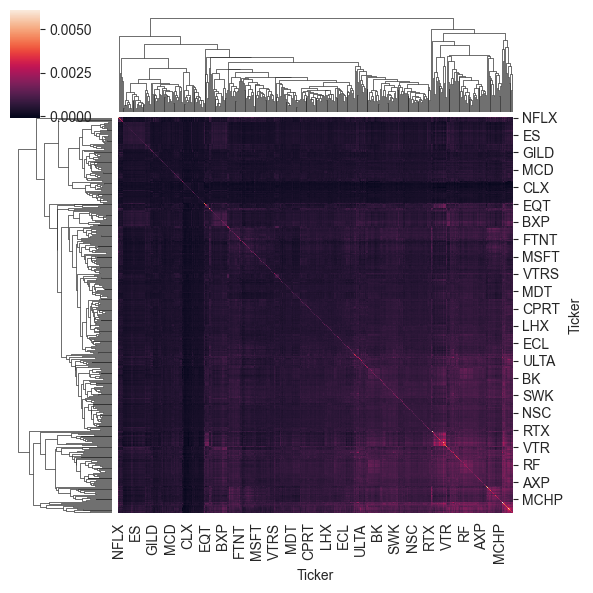

In [16]:
sns.clustermap(cov1, figsize = (6, 6))
plt.show()

In [17]:
corr1 = covariance_to_correlation(cov1)
corr1, clusters1, silh = clusterKMeansBase(
    corr1, 
    maxNumClusters = int(corr0.shape[0] / 2),
    n_init = 10
)

#### 군집 내 비중

NCO알고리즘의 두 번째 단계는 잡음이 제거된 공분산 행렬을 사용해 최적의 군집 내 배분을 계산하는 것이다. 아래의 코드는 이 절차를 구현한다. 단순성을 위해 배분 방법은 최소 분산 배분을 보여주나, 이 절차는 다른 대체적인 배분 방법의 사용도 허용한다. 추정된 군집 내 가중치를 사용해 군집 간 상관관계를 나타내는 축약된 공분산 행렬을 도출할 수 있다.

In [18]:
wIntra = pd.DataFrame(0, index = cov1.index, columns = clusters1.keys())
for i in clusters1 :
    wIntra.loc[clusters1[i], i] = optimizing_portfolio(cov1.loc[clusters1[i], clusters1[i]]).flatten()
cov2 = wIntra.T.dot(np.dot(cov1, wIntra))

In [22]:
print(cov2)

          0         1         2
0  0.000292  0.000099  0.000139
1  0.000099  0.000155  0.000080
2  0.000139  0.000080  0.000178


#### 군집 간 비중

NCO 알고리즘의 세 번째 단계는 축약된 공분산 행렬을 사용해 최적의 군집 간 배분을 계산하는 것이다. 구성상 이 공분산 행렬은 대각 행렬에 가깝고, 최적화 문제는 이상적인 Markowitz 사례에 가깝다. 즉 군집화와 군집 내 최적화 단계를 통해 Markowitz-cursed 문제를 올바르게 작동하는 문제로 전환할 수 있다. 아래의 코드는 이 절차를 구현한다. 군집 내 배분 단계에서 사용된 것과 동일한 배분 절차를 적용한다. 증권당 최종 배분은 Dataframe에 의해 표현되며, 이는 군집 내 비중과 군집 간 비중을 곱한 결과로 나타난다.

In [23]:
winter = pd.Series(optimizing_portfolio(cov2).flatten(), index = cov2.index)

In [25]:
print(winter)

0    0.034231
1    0.554372
2    0.411397
dtype: float64


In [26]:
wAII0 = wIntra.mul(winter, axis = 1).sum(axis = 1).sort_index()

In [31]:
ret.mean()

Ticker
A       0.003133
AAL     0.003671
AAPL    0.005196
ABT     0.002254
ACGL    0.003858
          ...   
XEL     0.001728
XOM     0.001296
YUM     0.002716
ZBH     0.001444
ZBRA    0.004558
Length: 433, dtype: float64